DataSet:
This dataset is from Kaggle. It contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Project Goal:
The goal of this project is to come up with a machine learning model that can predict fradulent transaction

Approach:
There are 28 columns in the dataset that are principal components of the original dataset. These are transformed versions of the original columns but still contain most of the variability. We have three additional columns that have not been transformed. Time, Amount and Class. I will use 30% of the observations for test and rest for training/cross-validation. Since, the dataset is imbalanced a confusion matrix is not a good measure of accuracy. Area under curve is a better measure of accuracy under these circumstances. A plot is drawn between True Positive Rate (Y-axis) and False Positive Rate (X-axis) for varying threshold. Bigger the area under curve represent better model. Maximum area under curve is 1 when all the oberservations are correctly classfied. Domain expertise is needed to pick a threshold.

True Positive Rate: It is the proportion of actual positives that are predicted as such. It is also called Sensitivity or Recall
True Negative Rate: It is the proportion of actual negatives that are predicted as such. It is also called specificity
False Positive Rate: 1 - True Negative Rate

In [20]:
import pandas as pd
import numpy  as np
import time
import matplotlib.pyplot as plt
fraud = pd.read_csv('creditcard.csv', header=0)

In [21]:
fraud.shape

(284807, 31)

In [22]:
fraud[fraud.isnull().sum(axis=1)>0]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


Good to know that we do not have NAs in our data

In [23]:
fraud.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

We have 492 cases of fraud and 284315 legit transactions

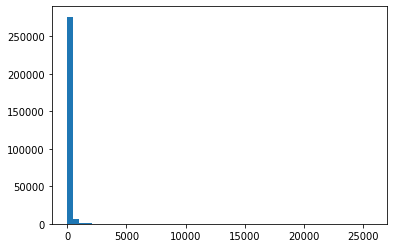

In [24]:
plt.hist(fraud.Amount, bins=50)
plt.show()

It appears majority of the transactions are linked with small amounts. Lets see if we can get a clearer picture.

In [25]:
fraud.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

75% of the transactions are below 77.165 and the max amount is 25691.16. Lets look at amount for fradulent and non-fradulent transactions separately.

In [26]:
fraud[fraud.Class==0].Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [27]:
fraud[fraud.Class==1].Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

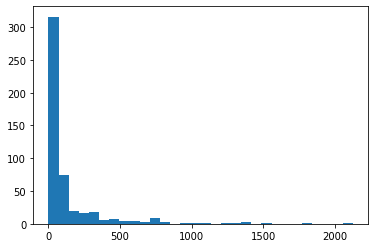

In [28]:
plt.hist(fraud[fraud.Class==1].Amount, bins=30)
plt.show()

Majority of the fraudulent transactions are also tied to small amounts. We have a few in thousands.

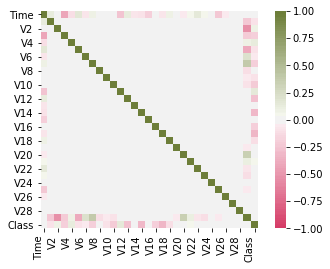

In [29]:
import seaborn as sns
corr = fraud.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(1, 100, n=100),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [30]:
#Lets build a simple logistic regression model first
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve

In [31]:
#Create train and test data from the dataset. Using 30% of the data for validation. Stratifying the data so we have same proportion of the classes in train and test set.
X = fraud.iloc[:,0:30].values
y = fraud.iloc[:,30].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50, stratify=y)

In [32]:
#train a logistic regression model and use it to predict class for the test set
lgr = LogisticRegression(max_iter=1000)
lgr.fit(X_train, y_train)
y_pred = lgr.predict(X_test)
y_prob = lgr.predict_proba(X_test)[:,1]

In [33]:
#Print classification report and 50% threshold
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.61      0.72       148

    accuracy                           1.00     85443
   macro avg       0.93      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [34]:
# Function to draw ROC plot
def draw_roc_plot(y_test, y_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    area = roc_auc_score(y_test, y_prob)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % area)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

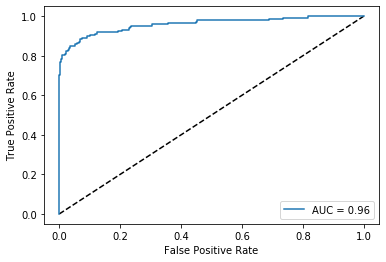

In [35]:
draw_roc_plot(y_test, y_prob)

Area of 0.96 is an indication of a pretty good model. Lets see if we improve it further by parameter tuning

In [36]:
from sklearn.model_selection import GridSearchCV

In [38]:
print(time.time())
#Set up the hyperparameter grid
c_space=np.logspace(-5, 8, 10)
#solver = ['lbfgs','saga']
param_grid = {'C': c_space}


#Instantiate LogisticRegression classifier
lgr = LogisticRegression(max_iter=1200)

#Instantiate GridSearchCV
lgr_cv = GridSearchCV(lgr, param_grid = param_grid, cv=5)

#Train Model
lgr_cv.fit(X_train, y_train)

#find best parameters
print(lgr_cv.best_params_)
best_C = lgr_cv.best_params_
print(time.time())

1583080037.104501
{'C': 3593813.6638046256}
1583080347.7773983


In [43]:
#refitting the model with optimum c value
lgr = LogisticRegression(max_iter=1200, C = best_C.get('C'))
lgr.fit(X_train, y_train)
y_pred = lgr.predict(X_test)
y_prob = lgr.predict_proba(X_test)[:,1]

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.61      0.72       148

    accuracy                           1.00     85443
   macro avg       0.93      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



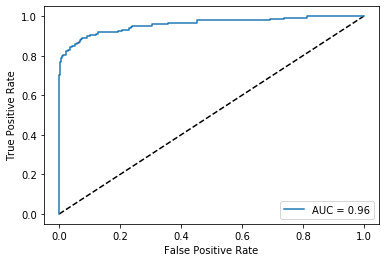

In [44]:
draw_roc_plot(y_test, y_prob)

There is no improvement in AUC. Lets try some other models

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
#Instantiate a RandomForest Classifier
rf = RandomForestClassifier()

print(time.time())

#Fit the model
rf.fit(X_train, y_train)

#Calculate probability of the outcome of both classes
y_prob = rf.predict_proba(X_test)[:,1]
print(time.time())

1583080920.3168519
1583081063.0230093


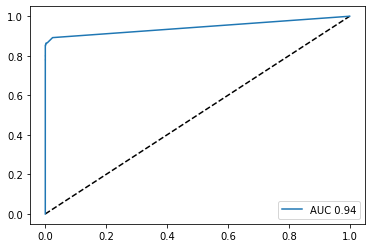

In [58]:
draw_roc_plot(y_test, y_prob)

Lets do some parameter tuning

In [49]:
print(time.time())
param_grid={'n_estimators':[100,200,500], 'max_depth':[4, 6]}

rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, param_grid=param_grid, cv=5)
rf_cv.fit(X_train, y_train)
print(time.time())

1583106551.4696443
1583109545.8125052


In [52]:
best = rf_cv.best_params_

{'max_depth': 6, 'n_estimators': 200}

In [54]:
rf = RandomForestClassifier(max_depth = best.get('max_depth'), n_estimators=best.get('n_estimators'))
rf.fit(X_train, y_train)
y_prob = rf.predict_proba(X_test)[:,1]
area = roc_auc_score(y_test, y_prob)

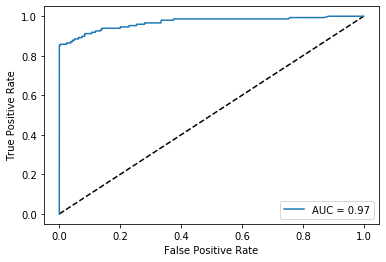

In [57]:
draw_roc_plot(y_test, y_prob)

AUC improved from 0.94 to 0.97 by using tuned parameters. Lets try GradientBoostingClassifier as well

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

In [74]:
#Instantiate GradientBoostingClassifier
gbc = GradientBoostingClassifier()

#Fit the model
gbc.fit(X_train, y_train)

#Calculate outcome probabilities
y_prob = gbc.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_prob)

0.7194106938875098

AUC of 0.72 is pretty low compared to our LogisticRegression and RandomForest models.

In [66]:
#Lets do some parameter tuning
param_grid = {'loss':['deviance', 'exponential'], 'n_estimators':[100,200,300]}
gbc = GradientBoostingClassifier()
gbc_cv = GridSearchCV(gbc, param_grid = param_grid, cv=5)
gbc_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [69]:
best = gbc_cv.best_params_

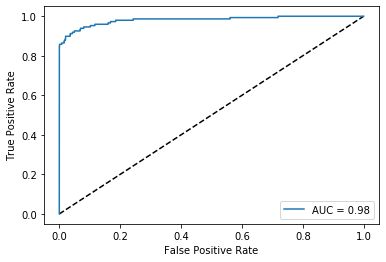

In [73]:
#lets refit the model using these tuned parameters
gbc = GradientBoostingClassifier(loss=best.get('loss'), n_estimators = best.get('n_estimators'))
gbc.fit(X_train,y_train)
y_prob = gbc.predict_proba(X_test)[:,1]
draw_roc_plot(y_test, y_prob)

Amazing, a gradient boosting classifier achieved AUC of 0.98. This beats LogisticRegresssion and RandomForest classifiers.